## Codificación de las variables categóricas y escalado

In [3]:
import pandas as pd 
import numpy as np
import sklearn
from sklearn.pipeline import Pipeline
from sklearn import metrics
!pip install category_encoders
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, \
                            silhouette_score, recall_score, precision_score, make_scorer, \
                            roc_auc_score, f1_score, precision_recall_curve, accuracy_score, roc_auc_score, \
                            classification_report, confusion_matrix

from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay

In [5]:
import os
print("Directorio actual:", os.getcwd())

Directorio actual: /Users/admin/Desktop/ap/practica1


In [6]:
os.chdir('/Users/admin/Desktop/ap/practica1/data')

In [9]:
pd_loan_train=pd.read_csv("train_pd_data_preprocessing_missing_outlier.csv")
pd_loan_test= pd.read_csv("test_pd_data_preprocessing_missing_outlier.csv")

In [10]:
pd_loan_train.columns

Index(['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE',
       'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'YEARS_BEGINEXPLUATATION_AVG', 'FLOORSMAX_AVG',
      

In [11]:
pd_loan_train.dtypes

SK_ID_CURR                 float64
NAME_CONTRACT_TYPE          object
CODE_GENDER                 object
FLAG_OWN_CAR                object
FLAG_OWN_REALTY             object
                            ...   
DAYS_BIRTH_YEARS           float64
DAYS_EMPLOYED_YEARS        float64
DAYS_REGISTRATION_YEARS    float64
DAYS_ID_PUBLISH_YEARS      float64
TARGET                     float64
Length: 85, dtype: object

## Separación train y test de la variable objetivo

In [8]:
# Separación de características (X) y variable objetivo (y)
X_train = pd_loan_train.drop('TARGET', axis=1)
X_test = pd_loan_test.drop('TARGET', axis=1)
y_train = pd_loan_train['TARGET']
y_test = pd_loan_test['TARGET']

# Verificar las dimensiones de los conjuntos
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (246008, 84)
X_test shape: (61503, 84)
y_train shape: (246008,)
y_test shape: (61503,)


In [13]:
# Identificar las columnas categóricas en X_train y X_test
list_columns_cat = list(X_train.select_dtypes(include=["object", "category"]).columns)

# Dividir variables categóricas en pocas categorías y muchas categorías
few_categories = [col for col in list_columns_cat if X_train[col].nunique() <= 10]
many_categories = [col for col in list_columns_cat if X_train[col].nunique() > 10]

# Verificar la clasificación de las variables categóricas
print("Variables con pocas categorías:", few_categories)
print("Variables con muchas categorías:", many_categories)

# Importar la librería para codificación
import category_encoders as ce

# Codificación para variables con pocas categorías: OneHotEncoder
ohe = ce.OneHotEncoder(cols=few_categories)
X_train_ohe = ohe.fit_transform(X_train)
X_test_ohe = ohe.transform(X_test)

# Codificación para variables con muchas categorías: CatBoostEncoder
catboost_encoder = ce.CatBoostEncoder(cols=many_categories, random_state=42)
X_train_catboost = catboost_encoder.fit_transform(X_train[many_categories], y_train)
X_test_catboost = catboost_encoder.transform(X_test[many_categories])

# Combinar los conjuntos codificados
X_train_combined = pd.concat([X_train_ohe.drop(columns=many_categories), X_train_catboost], axis=1)
X_test_combined = pd.concat([X_test_ohe.drop(columns=many_categories), X_test_catboost], axis=1)

# Verificar las dimensiones del conjunto transformado
print("Dimensiones de X_train después de combinar codificaciones:", X_train_combined.shape)
print("Dimensiones de X_test después de combinar codificaciones:", X_test_combined.shape)

# Opcional: Verificar los tipos de datos en el conjunto combinado
print("Tipos de datos en X_train_combined:", X_train_combined.dtypes.value_counts())

Variables con pocas categorías: ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'EMERGENCYSTATE_MODE']
Variables con muchas categorías: ['OCCUPATION_TYPE', 'ORGANIZATION_TYPE']
Dimensiones de X_train después de combinar codificaciones: (246008, 125)
Dimensiones de X_test después de combinar codificaciones: (61503, 125)
Tipos de datos en X_train_combined: float64    73
int64      52
Name: count, dtype: int64


Hemos utilizado un enfoque híbrido para codificar las variables categóricas según la cantidad de categorías:

##### __OneHotEncoding:__

__Aplicado a variables con pocas categorías (≤ 10).__

Es simple y efectivo, ya que no aumenta significativamente la dimensionalidad.

##### __CatBoostEncoder:__

__Utilizado para variables con muchas categorías (> 10).__

Reduce la dimensionalidad al transformar categorías en valores numéricos basados en su relación con la variable objetivo (TARGET).

__Justificación:__

Este enfoque equilibra la eficiencia computacional y la capacidad del modelo para capturar relaciones importantes.

Evitamos problemas de overfitting y complejidad excesiva, maximizando la información útil para el modelo.

Resultado: El dataset transformado es más manejable y adecuado para modelos avanzados como CatBoost, LightGBM o XGBoost.

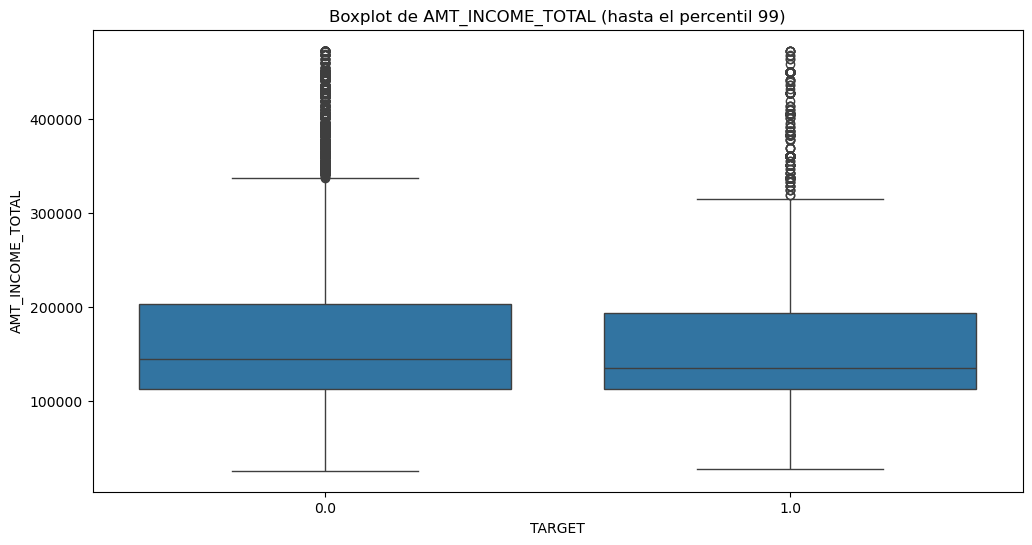

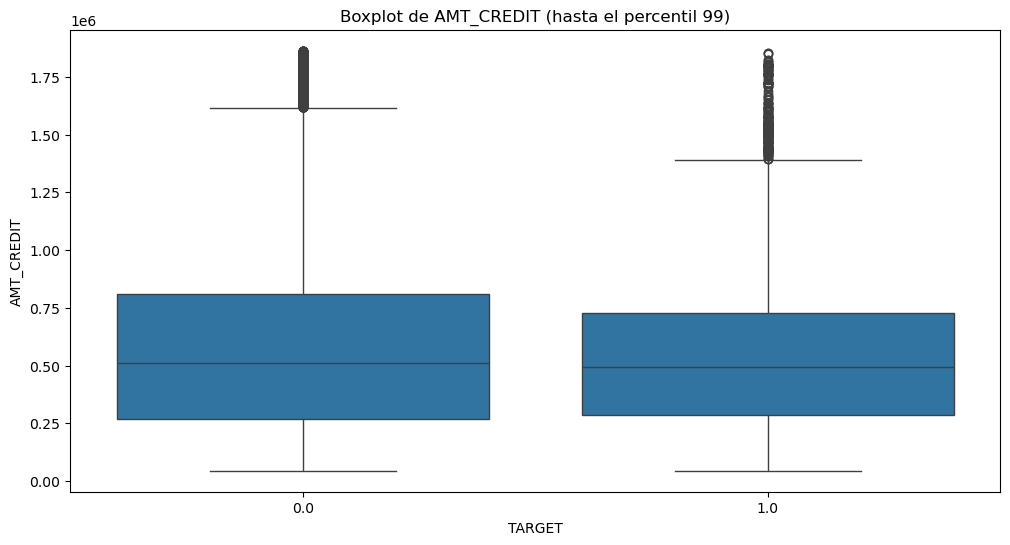

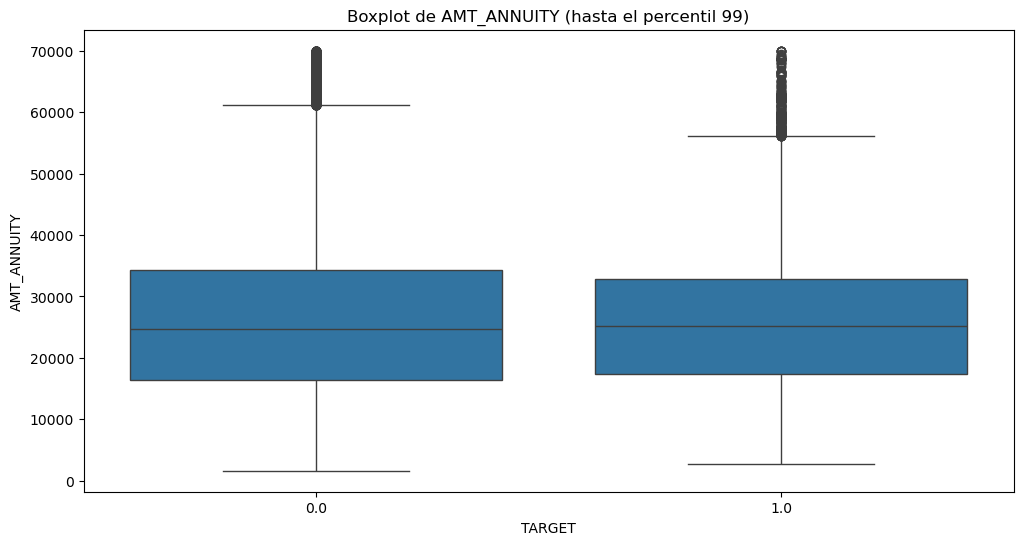

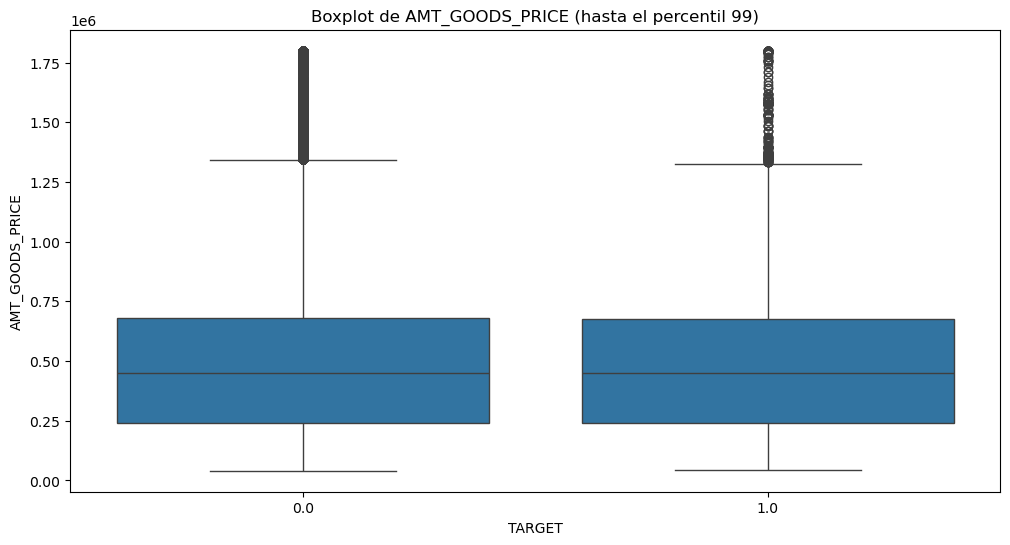

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Función para graficar con límites
def plot_boxplot_with_limits(df, col, target, upper_percentile=99):
    # Calcular los límites
    upper_limit = df[col].quantile(upper_percentile / 100)
    
    # Filtrar valores solo para la visualización
    df_filtered = df[df[col] <= upper_limit]
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df_filtered, x=target, y=col)
    plt.title(f'Boxplot de {col} (hasta el percentil {upper_percentile})')
    plt.show()

# Iterar para las variables continuas seleccionadas
vars_to_plot = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE']
data_grouped = pd.concat([X_train_combined[vars_to_plot], y_train], axis=1)
for var in vars_to_plot:
    plot_boxplot_with_limits(data_grouped, col=var, target='TARGET')

## Escalado de variables

In [14]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Inicializar el escalador
scaler = StandardScaler()

# Ajustar el escalador con los datos de entrenamiento y transformar
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_combined),
    columns=X_train_combined.columns,
    index=X_train_combined.index
)

# Transformar los datos de prueba
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_combined),
    columns=X_test_combined.columns,
    index=X_test_combined.index
)

# Mostrar las estadísticas descriptivas de las variables escaladas
print(X_train_scaled.describe())

         SK_ID_CURR  NAME_CONTRACT_TYPE_1  NAME_CONTRACT_TYPE_2  \
count  2.460080e+05          2.460080e+05          2.460080e+05   
mean   2.036787e-16          1.730086e-17          1.371938e-18   
std    1.000002e+00          1.000002e+00          1.000002e+00   
min   -1.734800e+00         -3.080851e+00         -3.245857e-01   
25%   -8.667085e-01          3.245857e-01         -3.245857e-01   
50%    5.510366e-04          3.245857e-01         -3.245857e-01   
75%    8.653543e-01          3.245857e-01         -3.245857e-01   
max    1.730775e+00          3.245857e-01          3.080851e+00   

       CODE_GENDER_1  CODE_GENDER_2  CODE_GENDER_3  FLAG_OWN_CAR_1  \
count   2.460080e+05   2.460080e+05   2.460080e+05    2.460080e+05   
mean    4.627042e-17   8.513238e-18   1.497398e-18    2.691526e-17   
std     1.000002e+00   1.000002e+00   1.000002e+00    1.000002e+00   
min    -1.387247e+00  -7.208392e-01  -2.851295e-03   -1.393863e+00   
25%    -1.387247e+00  -7.208392e-01  -2.851295

Con este proceso, las variables transformadas tienen media cercana a 0 y desviación estándar cercana a 1, lo que mejora la eficiencia en modelos sensibles a la escala.

NAME_CONTRACT_TYPE:
    - Vemos que los clientes que tienen mas dificultades para devolver el prestamo son los que piden prestamo en cash 

CODE_GENDER:
    - en relacion al total de prestamos, las mujeres piden más prestamos pero tienen menos dificultades para devolverlos, sin embargo los hombres piden menos y presentan mayor dificultad para devolverlos  

FLAG_OWN_CAR:
    - los clientes que no tienen coche piden más prestamos y tienen mas dificultades al devolverlo

FLAG_OWN_REALTY (si tienn casa o no):
    - los clientes que tienen casa piden más prestamos y tienen mayores dificultades. esto se puede deber a que los que tengan casa  es bastante proabñe que hayan solicitado una hipoteca para pagarla, y por lo tanto tienen más dificultades para pagar el prestamo

ATM_INCOME_TOTAL
    - Los clientes que tienen ingresos totales mas bajos tienen mas tendencia a tener mas dificultades en devolver los prestamos. aunque la diferencia no es muy sigmificativa, si que sigue siendo notable  

NAME_INCOME_TYPE
    - los clientes que estan trabajando, son mas propensos a pedir prestamos y a no devolverlos  

AMT_CREDIT:
    - la mayoria de los creditos se concentran en rangos bajos por debajo de 1M, sin ambargo, hay valores extremos significativos   

NAME_EDUCATION_TYPE
    - los clientes cuyo nivel maximo de estudios son la secundaria son loq ue más piden prestamos, pero estan igualados a la hora de poder o no devolverlos  

NAME_FAMILY_STATUS
    - los clientes casados tienen más propension a pedir prestamos, pero en general tienen mas dificultades para devolverlo, sin embargolos que estan casados por lo civil o los solteros piden menos prestamos pero tienen más dificultad a la hora de devolverlos  


NAME_HOUSING_TYPE
    - los clientes que viven en una casa o apartamento son los que mas prestamos piden pero no existen muchas diferencias en cuanto a la dificultad para devolverlos. destacar la diferencia de la cantidad de creditos respecto al resto de tipo de viviendas es muy alta .

OCCUPATION_TYPE
    - los clientes que más piden prestamos son los laborers y tienen más dificultad para devolverlo. tambien aquellas personas que no han querido rellenar el dato de su ocupacion, solicitan una cantidad importante de prestamos, lo cual es un detalle curioso y que nos lleva a preguntarnos por qué ocultan esta informacion


ORGANITATION_TYPE
    - en cuabto al tipos e organizacion en el que trabajan los clientes, predominan principalmente los prestamos a "business entity type 3" y autónomos. en le diccionario de datos no se especifica a que tipo de organizacion se corresponde "business entity type 3", pero hemos investigado concluyendo que son negocios familiaries o microempresas   
    - 







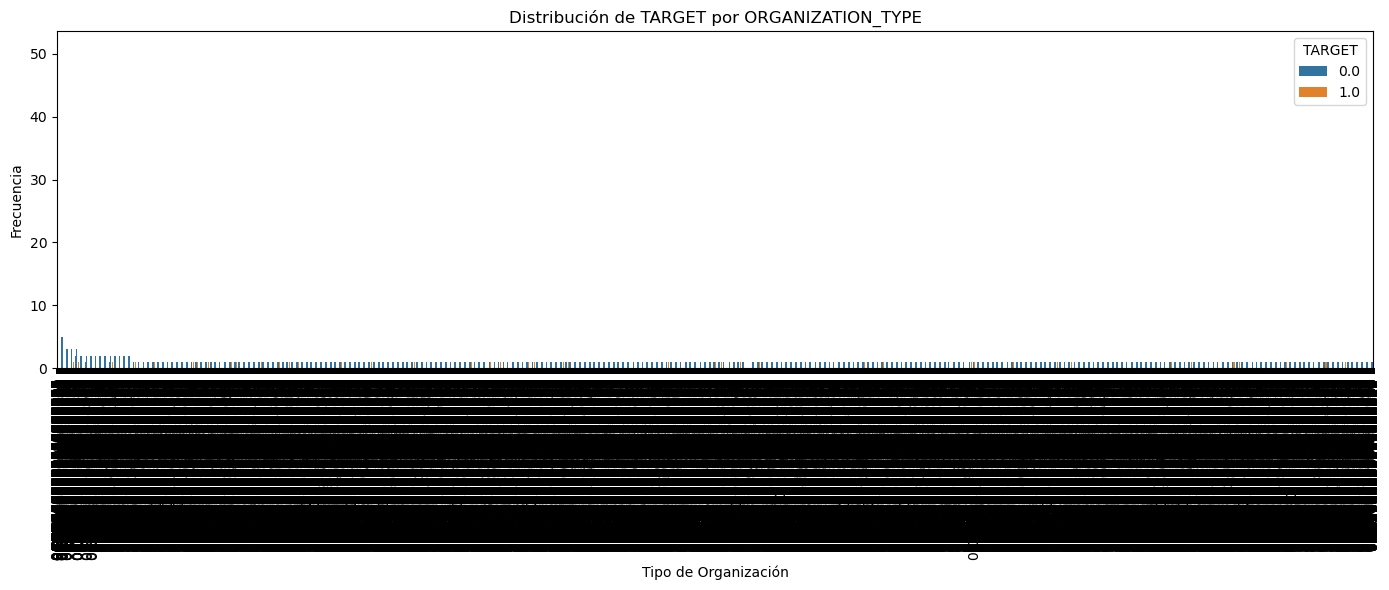

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear un nuevo DataFrame combinando X_train_combined y y_train
data_grouped = pd.concat([X_train_combined, y_train], axis=1)

# Distribución de ORGANIZATION_TYPE con respecto a TARGET
plt.figure(figsize=(14, 6))
sns.countplot(data=data_grouped, x='ORGANIZATION_TYPE', hue='TARGET', order=data_grouped['ORGANIZATION_TYPE'].value_counts().index)
plt.title('Distribución de TARGET por ORGANIZATION_TYPE')
plt.xlabel('Tipo de Organización')
plt.ylabel('Frecuencia')
plt.xticks(rotation=90)
plt.legend(title='TARGET')
plt.tight_layout()
plt.show()